<div style="text-align: center; background-color: #5A96E3; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Stage 02 - Exploratory Data Analysis
</div>

# 1. Import libraries

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sn

# 2. Read data

In [2]:
cleaned_data = pd.read_csv('../data/cleaned_data.csv')
cleaned_data

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,...,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers
0,Female,Excellent,0.0,3.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,No,...,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 70 to 74,1.60,67.13,26.22,Yes
1,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,No,...,No,Never smoked,Never used e-cigarettes in my entire life,No,Hispanic,Age 40 to 44,1.83,86.18,25.77,No
2,Female,Very good,0.0,0.0,Within past 2 years (1 year but less than 2 ye...,No,8.0,1 to 5,No,No,...,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 75 to 79,1.63,55.79,21.11,No
3,Female,Good,0.0,30.0,Within past year (anytime less than 12 months ...,No,7.0,None of them,No,No,...,No,Never smoked,Never used e-cigarettes in my entire life,No,"Black only, Non-Hispanic",Age 80 or older,1.75,72.57,23.63,No
4,Male,Good,12.0,0.0,Within past year (anytime less than 12 months ...,Yes,8.0,None of them,No,No,...,No,Former smoker,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 75 to 79,1.73,65.77,22.05,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7652,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,No,...,No,Former smoker,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 60 to 64,1.63,79.38,30.04,Yes
7653,Male,Good,0.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,No,...,No,Current smoker - now smokes some days,Use them every day,Yes,"White only, Non-Hispanic",Age 30 to 34,1.83,65.77,19.67,Yes
7654,Male,Good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,8.0,None of them,No,Yes,...,No,Former smoker,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 70 to 74,1.78,90.72,28.70,Yes
7655,Female,Fair,5.0,5.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,No,...,No,Never smoked,Not at all (right now),No,Hispanic,Age 18 to 24,1.57,68.04,27.44,No


# 3. Questions

## Question 1: Which indicators can affect heart attack most?

- **Purpose:** Understanding the factors that can influence the occurrence of a heart attack empowers us to take preventative measures and adjust our daily routines to mitigate these risk factors. 
- **How to answer:**
    - Select all people that have heart attack (the value of the `HadHeartAttack` column is equal to `Yes`).
    - Choose appropriate columns, we will choose all columns having only `Yes, No` values and three columns having multiple values `HadDiabetes, SmokerStatus, ECigaretteUsage`.
    - Preprocess columns having multiple values so that these columns only have `Yes, No` values.
    - Calculate the percentage of `Yes or No` values based on the meanings of the columns.

### Preprocessing

**Preprocess columns having multiple values**

First, we will check the unique values of these columns.

In [5]:
heart_attack_df = cleaned_data[cleaned_data['HadHeartAttack'] == 'Yes']

print(heart_attack_df['HadDiabetes'].value_counts())
print('================================================')
print(heart_attack_df['SmokerStatus'].value_counts())
print('================================================')
print(heart_attack_df['ECigaretteUsage'].value_counts())

No                                         189
Yes                                         93
No, pre-diabetes or borderline diabetes     15
Yes, but only during pregnancy (female)      1
Name: HadDiabetes, dtype: int64
Never smoked                             150
Former smoker                            102
Current smoker - now smokes every day     27
Current smoker - now smokes some days     19
Name: SmokerStatus, dtype: int64
Never used e-cigarettes in my entire life    210
Not at all (right now)                        75
Use them some days                             8
Use them every day                             5
Name: ECigaretteUsage, dtype: int64


Then, we convert these unique values to only `Yes No` values.

In [6]:
cleaned_data_copy = cleaned_data.copy()

cleaned_data_copy['HadDiabetes'] = cleaned_data_copy['HadDiabetes'].replace(['Yes, but only during pregnancy (female)', 
                                                                             'No, pre-diabetes or borderline diabetes'], ['Yes', 'Yes'])

cleaned_data_copy['SmokerStatus'] = cleaned_data_copy['SmokerStatus'].replace(['Never smoked', 'Former smoker', 
                                                                               'Current smoker - now smokes every day', 
                                                                               'Current smoker - now smokes some days'], 
                                                                              ['No', 'Yes', 'Yes', 'Yes'])

cleaned_data_copy['ECigaretteUsage'] = cleaned_data_copy['ECigaretteUsage'].replace(['Never used e-cigarettes in my entire life', 
                                                                                     'Not at all (right now)', 'Use them some days', 
                                                                                     'Use them every day'], ['No', 'No', 'Yes', 'Yes'])
cleaned_data_copy

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,...,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers
0,Female,Excellent,0.0,3.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,No,...,No,No,No,No,"White only, Non-Hispanic",Age 70 to 74,1.60,67.13,26.22,Yes
1,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,No,...,No,No,No,No,Hispanic,Age 40 to 44,1.83,86.18,25.77,No
2,Female,Very good,0.0,0.0,Within past 2 years (1 year but less than 2 ye...,No,8.0,1 to 5,No,No,...,No,No,No,No,"White only, Non-Hispanic",Age 75 to 79,1.63,55.79,21.11,No
3,Female,Good,0.0,30.0,Within past year (anytime less than 12 months ...,No,7.0,None of them,No,No,...,No,No,No,No,"Black only, Non-Hispanic",Age 80 or older,1.75,72.57,23.63,No
4,Male,Good,12.0,0.0,Within past year (anytime less than 12 months ...,Yes,8.0,None of them,No,No,...,No,Yes,No,No,"White only, Non-Hispanic",Age 75 to 79,1.73,65.77,22.05,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7652,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,No,...,No,Yes,No,No,"White only, Non-Hispanic",Age 60 to 64,1.63,79.38,30.04,Yes
7653,Male,Good,0.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,No,...,No,Yes,Yes,Yes,"White only, Non-Hispanic",Age 30 to 34,1.83,65.77,19.67,Yes
7654,Male,Good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,8.0,None of them,No,Yes,...,No,Yes,No,Yes,"White only, Non-Hispanic",Age 70 to 74,1.78,90.72,28.70,Yes
7655,Female,Fair,5.0,5.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,No,...,No,No,No,No,Hispanic,Age 18 to 24,1.57,68.04,27.44,No


**Select rows having `HadHeartAttack = Yes`**

In [7]:
heart_attack_df = cleaned_data_copy[cleaned_data_copy['HadHeartAttack'] == 'Yes']

Calculate the probability a person has heart attack under the condition he/she has one of the indicators that we think might lead to heart attack.

In [8]:
# Select columns having only yes and no values
yes_no_cols = heart_attack_df.columns[(heart_attack_df.isin(['Yes', 'No']).all()) & (heart_attack_df.columns != 'HadHeartAttack')]

# Seperate yes_no_cols into two different lists
# no_cols: a list containing all columns' names that we will use only No value
# yes_cols: a list containing all columns' names that we will use only Yes value
no_cols = ['PhysicalActivities', 'ChestScan']
yes_cols = yes_no_cols[~yes_no_cols.isin(no_cols)]

def count_yes(col):
    counts = col.value_counts()
    return counts['Yes']

def count_no(col):
    counts = col.value_counts()
    return counts['No']

# Calculate conditional probability
 # The number of people has the particular indicator
num_yes = cleaned_data_copy[yes_cols].agg(count_yes)
num_no = cleaned_data_copy[no_cols].agg(count_no)
num_has_indicator = pd.concat([num_yes, num_no])

# The number of people has both the particular indicator and heart attack
num_yes = heart_attack_df[yes_cols].agg(count_yes)
num_no = heart_attack_df[no_cols].agg(count_no)
num_has_indicator_heart_attack = pd.concat([num_yes, num_no])

prop_heart_attack_under_indicator = (num_has_indicator_heart_attack * 100 / num_has_indicator).round(2)
prop_heart_attack_under_indicator = prop_heart_attack_under_indicator.sort_values()

### Visualization

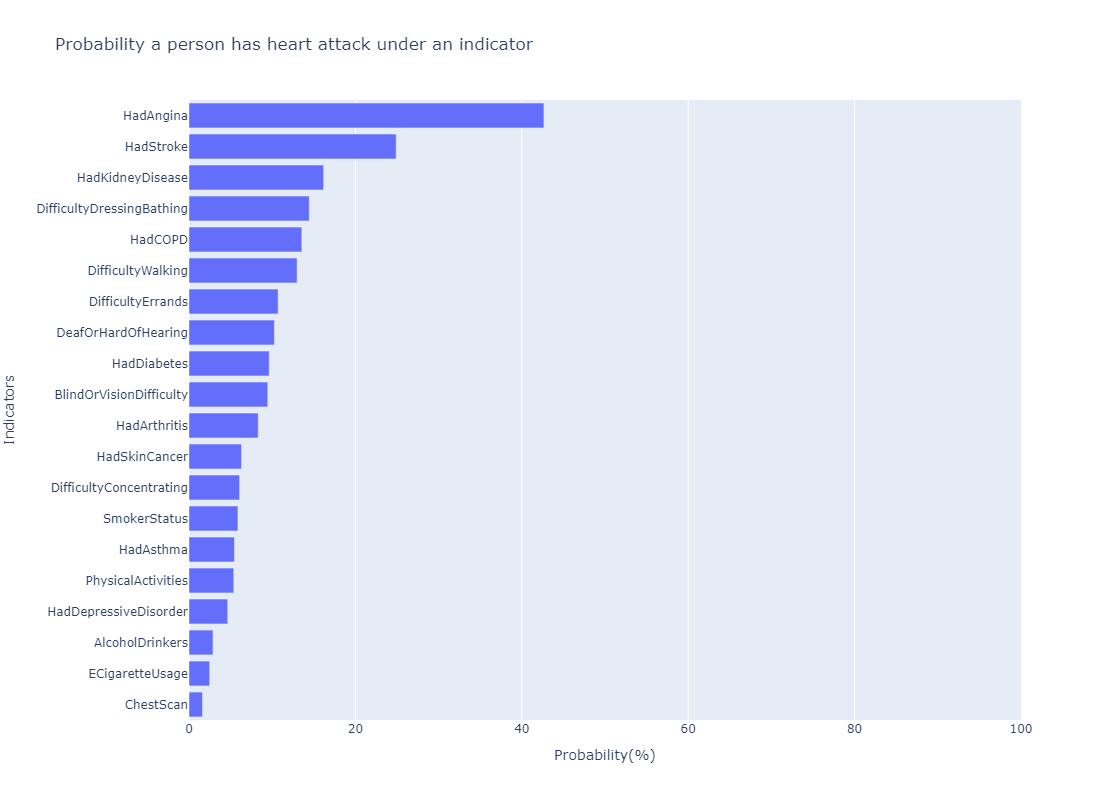

In [12]:
fig = px.bar(prop_heart_attack_under_indicator, x = prop_heart_attack_under_indicator.values, y = prop_heart_attack_under_indicator.index, 
             title = 'Probability a person has heart attack under an indicator', labels = {'x': 'Probability(%)', 'index': 'Indicators'}, range_x = (0, 100))
fig.update_layout(height=800, width=800)
fig.show()

### Observation

- We can see that the `HadAngina` and `HadStroke` columns have the highest probability **(42.66% and 24.9%)**, which means if a person has angina or stroke, he or she is more likely to have heart attack.
- The second highest probability includes `HadKidneyDisease` and `HadCOPD` with **16.18%** and **13.56%**.  
- The third to be considered is `HadDiabetes` and `HadArthritis` with **9.64%** and **8.32%**.

## Question 2:

- **Purpose:**
- **How to answer:**

### Preprocessing

### Visualization

### Observation

## Question 3:

- **Purpose:**
- **How to answer:**

### Preprocessing

### Visualization

### Observation